# FarmVibes.AI Nutrients Heatmap using optimal sensor/sample locations

This notebook is enhanced version of existing notebook [nutrients_using_classification.ipynb](). It generates the heatmap using the neighbor data points. The soil property data points were identified by optimal sensor/sample locations workflow. This notebook [notebooks/sensor/optimal_sample_collection.ipynb]() demonstrates generating a heatmap based on input imagery and nutrient information collected for the optimal sensor/sample locations.

This workflow ingests user data into the cluster. The reference to the data should be accessible via the internet and, for this demo, we assume it is saved in a remote location such as Azure blob storage.


### Micromamba environment setup
We provide a micromamba environment with the package requirements to run this notebook. If you do not have micromamba installed, please follow the instructions from the [micromamba installation guide](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html).

The micromamba environment can be created and activated using the commands below:

```bash
$ micromamba env create -f ./nutrients.yaml
$ micromamba activate nutrients
```

### Useful libraries

Below are the main libraries used for this example and other useful links:
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It Simple and efficient tools for predictive data analysis.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.

### Imports & API Client

In [1]:
from datetime import datetime
from vibe_core.client import get_default_vibe_client
import geopandas as gpd
from matplotlib import pyplot as plt
from notebook_lib import utils

## Workflow Inputs
The main workflow inputs are as follows:
- [farm_boundary](https://geojson.org/): Boundary of the field in geojson format. It is used to clip the satellite imagery to an area of interest and run the workflow. A sample field boundary is provided in the file `./sensor_farm_boundary.geojson`.

- imagery: Satellite imagery with multispectral bands to create raster indices. In this demo we are using Sentinel-2 imagery, which can be ingested by running a FarmVibes.AI workflow or a user provided url.

*Note - The provided sample data (sensor_farm_boundary.geojson, sensor_samples.geojson) is intended to help the user understand how to run the workflow and contains mock data.*

In [2]:
FARM_BOUNDARY = "./sensor_farm_boundary.geojson"

## Satellite imagery
Below we outline two methods for getting a raster that contains the satellite imagery used to generate the heatmap. Run the appropriate section below to ingest the data according to your preference.

### 1. Use the FarmVibes.AI workfow
FarmVibes.AI has several workflows that will ingest and preprocess data from many sources. Below we demonstrate how to obtain Sentinel-2 imagery for a desired location (our field boundary) and time range (some time around when the field samples were collected).

In [3]:
START_DATE=datetime(day=30, month=6, year=2022)
END_DATE=datetime(day=2, month=7, year=2022)

In [4]:
# sr_id: EPSG code for the coordinate system (CRS) used in the GeoJSON file
# containing the field boundary
# EPSG:4326 is the WGS-84 CRS (lat-lon) usually used in GeoJSON files
# Change this if your samples are provided in a different (projected) CRS
imagery = utils.get_raster_from_cluster(
    farm_boundary=FARM_BOUNDARY,
    time_range=(START_DATE, END_DATE),
    sr_id=4326
)

### 2. Ingest user-provided TIFF
Run this if you prefer ingesting your own raster into the cluster that already exist in azure storage account. The raster ingesting should have required bands to compute index in next section. 

For example, if you're ingesting the Sentinel Raster then bands should be mapped as below. It's the format supported by [Spyndex library](https://github.com/awesome-spectral-indices/awesome-spectral-indices#expressions)

{'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3, 'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7, 'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11}

If you are ingesting the custom multi spectral raster image that has three bands representing red, blue and nir then bands should be mapped as below.

{"R": 0, "B": 1, "N": 2}

Note: To map the bands for Sentinel, Landsat etc., look at respective columns in [Spyndex library documentation](https://github.com/awesome-spectral-indices/awesome-spectral-indices#expressions), if column not found then map the bands based on column "Standard"


In [ ]:
# Url the cluster will use to access the file, e.g., a signed blob URL
IMAGERY_URL = "<SAS URL>"

In [ ]:
# Ingest the data into the cluster. A `Raster` is returned
imagery = utils.get_raster_from_external(imagery_url=IMAGERY_URL, farm_boundary=FARM_BOUNDARY)
# Set the bands so that we know which band is what when computing indices
# These are the band names for an L2A Sentinel-2 raster
imagery.bands = {'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3, 'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7, 'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11}

### Optimal Locations with nutrient information

Upload the nutrients associated with optimal sensor/sample locations and cluster_boundaries to storage account and get the SAS url. The SAS url generated should be accessible through the internet since it will be downloaded from FarmVibes.AI cluster.

We provide an example of attribute and geometry information in the file `sensor_samples.geojson`.

In [19]:
cluster_boundaries_url = "<SAS URL>"
nutrients_url = "<SAS URL>"

## Heatmap workflow

In [6]:
client = get_default_vibe_client()
client.document_workflow("farm_ai/agriculture/heatmap_using_neighboring_data_points")

Workflow: farm_ai/agriculture/heatmap_using_neighboring_data_points

Description:

Creates heatmap using the neighbors by performing spatial interpolation operations. It utilizes 
    soil information collected at optimal sensor/sample locations and downloaded sentinel satellite 
    imagery. The optimal location of nutrient samples are identified using workflow                 
    <farm_ai/sensor/optimal_locations>. The quantity of samples defines the accuracy of the heatmap 
    generation. During the research performed testing on a 100 acre farm using sample count of      
    approximately 20, 80, 130, 600. The research concluded that a sample count of 20 provided decent
    results, also accuracy of nutrient information improved with increase in sample count.

Sources:

- input_raster (vibe_core.data.rasters.Raster): Sentinel-2 raster.

- input_samples (List[vibe_core.data.core_types.ExternalReferenceList]): Sensor samples with    
    nutrient information.

- input_sample_clusters (List[vibe_core.data.core_types.ExternalReferenceList]): Clusters       
    boundaries of sensor samples locations.

Sinks:

- result (vibe_core.data.core_types.DataVibe): Zip file containing heatmap output as shape      
    files.

Parameters:

- attribute_name (default: C): Nutrient property name in sensor samples geojson file. For       
    example: CARBON (C), Nitrogen (N), Phosphorus (P) etc.,

- simplify (default: simplify): Replace small polygons in input with value of their largest     
    neighbor after converting from raster to vector. Accepts 'simplify' or 'convex' or 'none'.

- tolerance (default: 1.0): All parts of a [simplified                                          
    geometry](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) 
    will be no more than tolerance distance from the original. It has the same units as the         
    coordinate reference system of the GeoSeries. For example, using tolerance=100 in a projected   
    CRS with meters as units means a distance of 100 meters in reality.

- algorithm (default: nearest neighbor): Algorithm used to identify nearest neighbors. Accepts  
    'cluster overlap' or 'nearest neighbor' or 'kriging neighbor'.

- resolution (default: 5): Defines the output resolution as the ratio of input raster           
    resolution. For example, if resolution is 5, the output heatmap is 5 times coarser than input   
    raster.

- bins (default: 5): it defines the number of equal-width bins in the given range.Refer to this 
    article to learn more about bins                                                                
    https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

Tasks:

- download_samples: Adds user geometries into the cluster storage, allowing for them to be used 
    on workflows.

- download_sample_clusters: Adds user geometries into the cluster storage, allowing for them to 
    be used on workflows.

- soil_sample_heatmap: Generate heatmap for nutrients using satellite or spaceEye imagery.

## Generating a Carbon heatmap
We demonstrate how to generate a carbon heatmap using the Enhanced Vegetation Index (EVI). In the provided sample file, the sensor samples have carbon information in attribute "C". Parameters for a workflow run are defined in a dict as shown below.

In [7]:
# input parameters
parameters = {
        "attribute_name": "C",
        "simplify": "simplify",
        "tolerance": 1,
        "algorithm":"cluster overlap",
        "resolution": 3,
        "bins":5
        }

shape_file_path, raster_path = utils.create_heatmap_using_neighbors(
        imagery=imagery,
        samples_boundary_url=cluster_boundaries_url,
        samples_url=nutrients_url,
        farm_boundary = FARM_BOUNDARY,
        parameters = parameters
)

In [8]:
utils.calculate_accuracy(nutrients_url, FARM_BOUNDARY, raster_path, "C")

{'mae': 0.0001480257315825597,
 'rmse': 0.00031069752978528945,
 'relative_error': 0.0022180167504714664}

### Output visualization
We use matplotlib and geopandas to display the results of the workflow from the shapefiles. This is a quick way to get a high level view the workflow output. To get a more detailed look, we recommend opening the generated files and input raster in a geographic analysis platform, such as [QGIS](https://www.qgis.org/en/site/). This will allow you to zoom in and more closely examine the results.

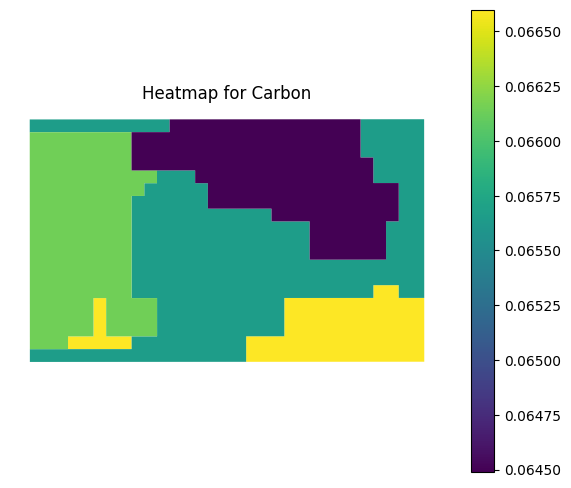

In [9]:
utils.view_output(shape_file_path, title="Heatmap for Carbon")

## Generating a Nitrogen heatmap
We demonstrate how to generate a nitrogen heatmap using the Enhanced Vegetation Index (EVI). In the provided sample file, the sensor samples have nitrogen information in attribute "N". Parameters for a workflow run are defined in a dict as shown below.

In [10]:
# input parameters
parameters = {
        "attribute_name": "N",
        "simplify": "simplify",
        "tolerance": 1,
        "algorithm":"nearest neighbor",
        "resolution": 5,
        "bins":5
        }

shape_file_path, raster_path = utils.create_heatmap_using_neighbors(
        imagery=imagery, 
        samples_boundary_url=cluster_boundaries_url,
        samples_url=nutrients_url,
        farm_boundary = FARM_BOUNDARY,
        parameters = parameters
)

### Output visualization
We use matplotlib and geopandas to display the results of the workflow from the shapefiles. This is a quick way to get a high level view the workflow output. To get a more detailed look, we recommend opening the generated files and input raster in a geographic analysis platform, such as [QGIS](https://www.qgis.org/en/site/). This will allow you to zoom in and more closely examine the results.

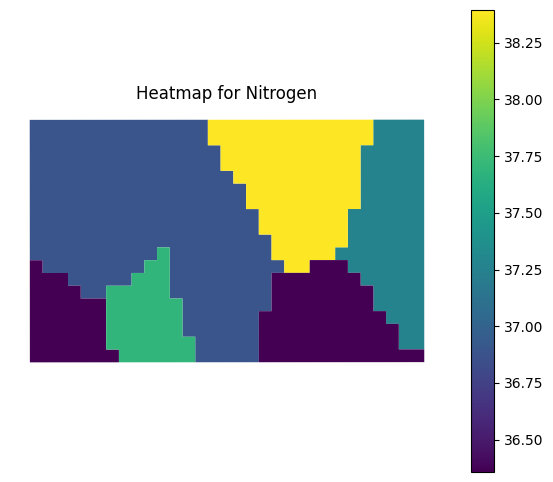

In [11]:
utils.view_output(shape_file_path, title="Heatmap for Nitrogen")

In [12]:
utils.calculate_accuracy(nutrients_url, FARM_BOUNDARY, raster_path, "N")

{'mae': 0.20921648387340408,
 'rmse': 0.5420335800524969,
 'relative_error': 0.005774186670234012}

## Generating a Phosphorus heatmap
The information about phosphorus is available in the attribute `P`, so we change the parameter accordingly. We also use EVI for this parameter.

In [13]:
# input parameters
parameters = {
        "attribute_name": "P",
        "simplify": "simplify",
        "tolerance": 1,
        "algorithm":"nearest neighbor",
        "resolution": 5,
        "bins":5
        }

shape_file_path, raster_path = utils.create_heatmap_using_neighbors(
        imagery=imagery, 
        samples_boundary_url=cluster_boundaries_url,
        samples_url=nutrients_url,
        farm_boundary = FARM_BOUNDARY,
        parameters = parameters
)

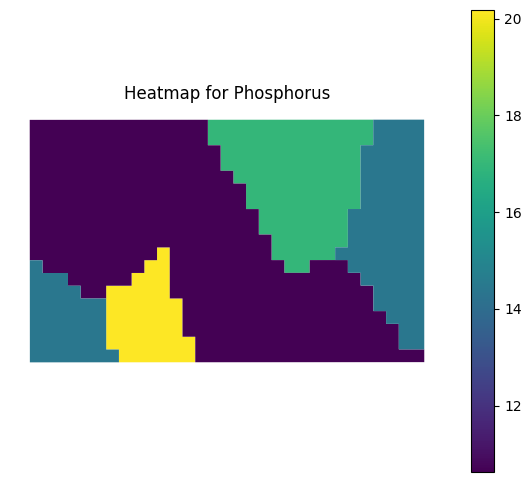

In [14]:
utils.view_output(shape_file_path, title="Heatmap for Phosphorus")

In [15]:
utils.calculate_accuracy(nutrients_url, FARM_BOUNDARY, raster_path, "P")

{'mae': 1.1603435184289237,
 'rmse': 2.22361920087616,
 'relative_error': 0.08910255273466096}

## Generating a pH heatmap
We found that the Photochemical Reflectance Index (PRI) has better correlation with pH values, so we adjust the index as well. Get sample location for index PRI. For identified latitude & longitude of sample locations derive nutrient information. Upload derived information and sample location boundaries to storage account and get SAS Url.

In [ ]:
cluster_boundaries_url = "<SAS URL>"
nutrients_url = "<SAS URL>"

In [16]:
# input parameters
parameters = {
        "attribute_name": "pH",
        "simplify": "simplify",
        "tolerance": 1,
        "algorithm":"nearest neighbor",
        "resolution": 5,
        "bins":5
        }

shape_file_path, raster_path = utils.create_heatmap_using_neighbors(
        imagery=imagery, 
        samples_boundary_url=cluster_boundaries_url,
        samples_url=nutrients_url,
        farm_boundary = FARM_BOUNDARY,
        parameters = parameters
)

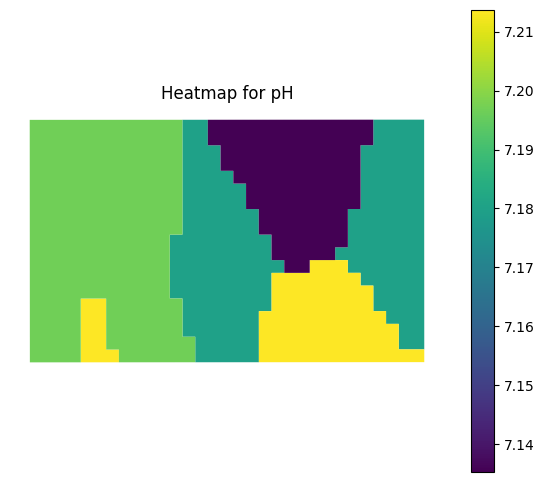

In [17]:
utils.view_output(shape_file_path, title="Heatmap for pH")

In [18]:
utils.calculate_accuracy(nutrients_url, FARM_BOUNDARY, raster_path, "pH")

{'mae': 0.005409858200285278,
 'rmse': 0.011353036453740525,
 'relative_error': 0.0007494613328657269}